In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


#Policy Gradient

In [ ]:
# https://deeplearningcourses.com/c/deep-reinforcement-learning-in-python
# https://www.udemy.com/deep-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future
# Inspired by https://github.com/dennybritz/reinforcement-learning

import gym
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime

In [ ]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()


##Policy Gradient

In [ ]:

# so you can test different architectures
class HiddenLayer:
  def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):
    self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
    self.use_bias = use_bias
    if use_bias:
      self.b = tf.Variable(np.zeros(M2).astype(np.float32))
    self.f = f

  def forward(self, X):
    if self.use_bias:
      a = tf.matmul(X, self.W) + self.b
    else:
      a = tf.matmul(X, self.W)
    return self.f(a) #applies tanh activation functon on Z


In [ ]:
x = tf.placeholder(tf.float32,[None,784])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x,W)+b)
y_ = tf.placeholder(tf.float32,[None,10])
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
optimizer = tf.train.GradientDescentOptimizer(0.01)

#gradstep = opt.compute_gradients(cross_entropy)
gradients2, variables2 = zip(*optimizer.compute_gradients(cross_entropy))

sess2 = tf.Session()
sess2.run(tf.initialize_all_variables())
for i in range(2):
  gradients2, variables2 = zip(*optimizer.compute_gradients(cross_entropy))
  gradients2 = sess2.run([tf.clip_by_norm(gradient, 5.0)
      for gradient in gradients2 if gradient is not None], feed_dict={x: np.random.randn(10,784), y_:np.random.randn(10,10)})

  optimize = optimizer.apply_gradients(zip(gradients2, variables2))

  sess2.run(optimize)
  print(gradients2)


In [ ]:
# approximates pi(a | s)
#linear model for policy, and NN for value function
class PolicyModel:
  def __init__(self, D, K, hidden_layer_sizes):
    # create the graph
    # K = number of actions
    self.layers = []
    M1 = D
    for M2 in hidden_layer_sizes:
      layer = HiddenLayer(M1, M2)
      self.layers.append(layer)
      M1 = M2

    self.temp = 1 #Temporary variable
    # final layer
    # layer = HiddenLayer(M1, K, lambda x: x, use_bias=False)
    layer = HiddenLayer(M1, K, tf.nn.softmax, use_bias=False)
    self.layers.append(layer)

    # inputs and targets
    self.X = tf.placeholder(tf.float32, shape=(None, D), name='X') #shape (n,d)
    self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions') #shape(K,) number of actions
    self.advantages = tf.placeholder(tf.float32, shape=(None,), name='advantages') #shape(n,)

    # calculate output and cost
    Z = self.X
    for layer in self.layers:
      Z = layer.forward(Z)
    p_a_given_s = Z #(None,D)

    # action_scores = Z
    # p_a_given_s = tf.nn.softmax(action_scores)
    # self.action_scores = action_scores
    #print("Z",Z.shape)

    self.predict_op = p_a_given_s

    # self.one_hot_actions = tf.one_hot(self.actions, K)

    selected_probs = tf.log(
      tf.reduce_sum(
        p_a_given_s * tf.one_hot(self.actions, K),
        reduction_indices=[1]  #columnwise sum of the probabilities
      )
    )

    #print("Selected probs",selected_probs.shape)
    #print("advantages",self.advantages.shape)
    #print("actions",self.actions.shape)
    # self.selected_probs = selected_probs
    #self.cost = -tf.reduce_sum(self.advantages * selected_probs) 
    cost = -tf.reduce_sum(self.advantages * selected_probs) 
    # self.cost = cost
    self.train_op = tf.train.AdamOptimizer(1e-1).minimize(cost)
    #self.train_op = tf.train.AdagradOptimizer(1e-1).minimize(cost)
    # self.train_op = tf.train.MomentumOptimizer(1e-4, momentum=0.9).minimize(cost)
    #self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

    #self.optimizer = tf.train.AdagradOptimizer(1e-1)
    #self.gradients,self.variables = zip(*self.optimizer.compute_gradients(self.cost))   
    #self.apply = self.optimizer.apply_gradients(zip(self.gradients,self.variables))

    

  def set_session(self, session):
    self.session = session

  def partial_fit(self, X, actions, advantages): #in MC X is something like ((pos,vel,theta,omega),()....) the samples same for actions and advantages except that they are scalar
    #print("before X",len(X))
    X = np.atleast_2d(X)
    #print("after X",X.shape)
    #print("before actions",len(actions))

    actions = np.atleast_1d(actions)
    #print("after actions",actions.shape)
    #print("before advantages",len(advantages))
    
    advantages = np.atleast_1d(advantages)
    #print("after advantages",advantages.shape)

    self.session.run(
      self.train_op,
      feed_dict={
        self.X: X,
        self.actions: actions,
        self.advantages: advantages,
      }
    )
    # gradients,variables = zip(*self.optimizer.compute_gradients(self.cost)) 
    # gradients = self.session.run([grad for grad in gradients if grad is not None], feed_dict={self.X: X, self.actions: actions, self.advantages: advantages,})
    # apply = self.optimizer.apply_gradients(zip(gradients,variables))
    # # var_to_grad = {}
    # # for grad_val, (_, var) in zip(grad_vals, gradstep): 
    # #   var_to_grad[var.name] = grad_val
    # #   if(self.temp is 1):
    # #     print(grad_val.shape)
    # # self.temp = 2   
    # # print("Gradients",var_to_grad) 
    # # if self.temp is 1:
    # #   print(type(grad_vals))
    # #   print(len(grad_vals))
    # #   print(type(grad_vals[0]))
    # # self.temp = 2  
    # if(self.temp is 1):
    #   self.session.run(tf.initialize_all_variables())
    #   self.temp = 2
    # self.session.run(apply)
    #print(gradients)

  def predict(self, X):
    X = np.atleast_2d(X)
    res =  self.session.run(self.predict_op, feed_dict={self.X: X})
   # print(res.shape) returns a (1,2) shape vector containing the probabilities of both the actions
    return res

  def sample_action(self, X):
    p = self.predict(X)[0] #the first row or a 1D vector containing 2 actions
    return np.random.choice(len(p), p=p) #return a single action 0 index corresponding to left/right action, with the respective probabilities given  


In [ ]:
# approximates V(s)
class ValueModel:
  def __init__(self, D, hidden_layer_sizes):
    # create the graph
    self.layers = []
    M1 = D
    for M2 in hidden_layer_sizes:
      layer = HiddenLayer(M1, M2)
      self.layers.append(layer)
      M1 = M2
    self.temp = 1
    # final layer
    layer = HiddenLayer(M1, 1, lambda x: x)
    self.layers.append(layer)

    # inputs and targets
    self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    self.Y = tf.placeholder(tf.float32, shape=(None,), name='Y')

    # calculate output and cost
    Z = self.X
    for layer in self.layers:
      Z = layer.forward(Z)
    Y_hat = tf.reshape(Z, [-1]) # the output
    self.predict_op = Y_hat

    cost = tf.reduce_sum(tf.square(self.Y - Y_hat))
    #self.train_op = tf.train.AdamOptimizer(1e-2).minimize(cost)
    # self.train_op = tf.train.MomentumOptimizer(1e-2, momentum=0.9).minimize(cost)
    #self.optimizer2 = tf.train.GradientDescentOptimizer(1e-4)
    self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

  def set_session(self, session):
    self.session = session

  def partial_fit(self, X, Y):
    X = np.atleast_2d(X)
    Y = np.atleast_1d(Y)
    self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})

    # gradients2,variables2 = zip(*self.optimizer2.compute_gradients(self.cost2)) 
    # gradients2 = self.session2.run([grad for grad in gradients2 if grad is not None], feed_dict={self.X: X, self.Y: Y})
    # apply2 = self.optimizer2.apply_gradients(zip(gradients2,variables2))

    # if(self.temp is 1):
    #   self.session2.run(tf.initialize_all_variables())
    #   self.temp = 2
    # self.session2.run(apply2)
    # self.session2.close()

  def predict(self, X):
    X = np.atleast_2d(X)
    return self.session.run(self.predict_op, feed_dict={self.X: X})


In [ ]:
def play_one_td(env, pmodel, vmodel, gamma):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0

  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = pmodel.sample_action(observation)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    # if done:
    #   reward = -200

    # update the models
    V_next = vmodel.predict(observation)[0]
    G = reward + gamma*V_next
    advantage = G - vmodel.predict(prev_observation)
    pmodel.partial_fit(prev_observation, action, advantage)
    vmodel.partial_fit(prev_observation, G)

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  return totalreward

In [ ]:
def play_one_mc(env, pmodel, vmodel, gamma):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0

  states = []
  actions = []
  rewards = []

  reward = 0
  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = pmodel.sample_action(observation)

    states.append(observation)
    actions.append(action)
    rewards.append(reward)

    prev_observation = observation
    observation, reward, done, info = env.step(action)

    if done:
      reward = -200

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  # save the final (s,a,r) tuple
  action = pmodel.sample_action(observation)
  states.append(observation)
  actions.append(action)
  rewards.append(reward)

  returns = []
  advantages = []
  G = 0
  for s, r in zip(reversed(states), reversed(rewards)):
    returns.append(G)
    advantages.append(G - vmodel.predict(s)[0])
    G = r + gamma*G
  returns.reverse()
  advantages.reverse()

  # update the models
  pmodel.partial_fit(states, actions, advantages)
  vmodel.partial_fit(states, returns)

  return totalreward

In [ ]:
env = gym.make('CartPole-v0')
print("Testing ",env.observation_space.shape)
D = env.observation_space.shape[0]
print(D)

Testing  (4,)
4


Testing  (4,)
episode: 0 total reward: 12.0 avg reward (last 100): 12.0
episode: 100 total reward: 115.0 avg reward (last 100): 37.603960396039604
episode: 200 total reward: 199.0 avg reward (last 100): 160.68316831683168
episode: 300 total reward: 199.0 avg reward (last 100): 193.40594059405942
episode: 400 total reward: 199.0 avg reward (last 100): 197.34653465346534
episode: 500 total reward: 199.0 avg reward (last 100): 194.41584158415841
episode: 600 total reward: 199.0 avg reward (last 100): 199.0
episode: 700 total reward: 199.0 avg reward (last 100): 199.0
episode: 800 total reward: 199.0 avg reward (last 100): 199.0
episode: 900 total reward: 199.0 avg reward (last 100): 199.0
avg reward for last 100 episodes: 198.02
total steps: 177620.0


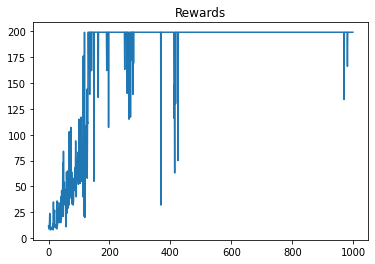

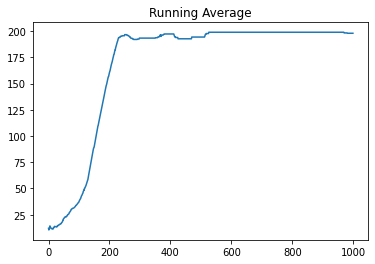

In [ ]:
def main():
  env = gym.make('CartPole-v0')
  print("Testing ",env.observation_space.shape)
  D = env.observation_space.shape[0]
  K = env.action_space.n
  pmodel = PolicyModel(D, K, [])
  vmodel = ValueModel(D, [10])
  init = tf.global_variables_initializer()
  session = tf.InteractiveSession()
  session.run(init)
  #session2 = tf.InteractiveSession()
  #session2.run(init)
  pmodel.set_session(session)
  vmodel.set_session(session)
  gamma = 0.99

  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)

  N = 1000
  totalrewards = np.empty(N)
  costs = np.empty(N)
  for n in range(N):
    totalreward = play_one_mc(env, pmodel, vmodel, gamma)
    totalrewards[n] = totalreward
    if n % 100 == 0:
      print("episode:", n, "total reward:", totalreward, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
  print("total steps:", totalrewards.sum())

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

  plot_running_avg(totalrewards)


if __name__ == '__main__':
  main()


##Deep Q Learning

episode: 0 total reward: 27.0 eps: 1.0 avg reward (last 100): 27.0
episode: 100 total reward: 87.0 eps: 0.09950371902099892 avg reward (last 100): 121.35643564356435
episode: 200 total reward: 200.0 eps: 0.07053456158585983 avg reward (last 100): 169.5148514851485
episode: 300 total reward: 190.0 eps: 0.0576390417704235 avg reward (last 100): 162.35643564356437
episode: 400 total reward: 200.0 eps: 0.04993761694389223 avg reward (last 100): 156.7029702970297
episode: 500 total reward: 200.0 eps: 0.04467670516087703 avg reward (last 100): 152.2970297029703
episode: 600 total reward: 50.0 eps: 0.04079085082240021 avg reward (last 100): 146.47524752475246
episode: 700 total reward: 200.0 eps: 0.0377694787300249 avg reward (last 100): 138.8118811881188
episode: 800 total reward: 19.0 eps: 0.03533326266687867 avg reward (last 100): 121.25742574257426
episode: 900 total reward: 39.0 eps: 0.03331483023263848 avg reward (last 100): 125.61386138613861
avg reward for last 100 episodes: 104.43
to

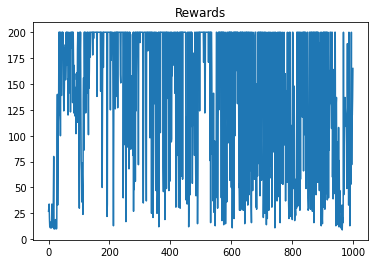

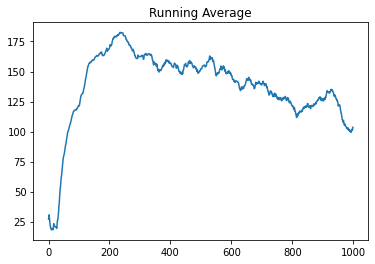

In [ ]:
# https://deeplearningcourses.com/c/deep-reinforcement-learning-in-python
# https://www.udemy.com/deep-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import gym
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime


# global counter
global_iters = 0


# a version of HiddenLayer that keeps track of params
class HiddenLayer:
  def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):
    self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
    self.params = [self.W]
    self.use_bias = use_bias
    if use_bias:
      self.b = tf.Variable(np.zeros(M2).astype(np.float32))
      self.params.append(self.b)
    self.f = f

  def forward(self, X):
    if self.use_bias:
      a = tf.matmul(X, self.W) + self.b
    else:
      a = tf.matmul(X, self.W)
    return self.f(a)

#2 hidden layers used with 200 hidden units each 

class DQN:
  def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences=10000, min_experiences=100, batch_sz=32):
    self.K = K

    # create the graph
    self.layers = []
    M1 = D
    for M2 in hidden_layer_sizes:
      layer = HiddenLayer(M1, M2)
      self.layers.append(layer)
      M1 = M2

    # final layer
    layer = HiddenLayer(M1, K, lambda x: x)
    self.layers.append(layer)
    self.temp = 1
    # collect params for copy
    self.params = []
    for layer in self.layers:
      self.params += layer.params

    # inputs and targets
    self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    self.G = tf.placeholder(tf.float32, shape=(None,), name='G')
    self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')

    # calculate output and cost
    Z = self.X
    for layer in self.layers:
      Z = layer.forward(Z)
    Y_hat = Z
    self.predict_op = Y_hat

    selected_action_values = tf.reduce_sum(
      Y_hat * tf.one_hot(self.actions, K),
      reduction_indices=[1]
    )
    #print("G size ")
    #self.cost = tf.reduce_sum(tf.square(self.G - selected_action_values))
    cost = tf.reduce_sum(tf.square(self.G - selected_action_values))
   # self.optimizer = tf.train.AdamOptimizer(1e-2)
    self.train_op = tf.train.AdamOptimizer(1e-2).minimize(cost)
    #self.train_op = tf.train.AdagradOptimizer(1e-2).minimize(cost)
    # self.train_op = tf.train.MomentumOptimizer(1e-3, momentum=0.9).minimize(cost)
    # self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

    # create replay memory
    self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
    self.max_experiences = max_experiences
    self.min_experiences = min_experiences
    self.batch_sz = batch_sz
    self.gamma = gamma

  def set_session(self, session):
    self.session = session

  def copy_from(self, other):
    # collect all the ops
    ops = []
    my_params = self.params
    other_params = other.params
    for p, q in zip(my_params, other_params):
      actual = self.session.run(q)
      op = p.assign(actual)
      ops.append(op)
    # now run them all
    self.session.run(ops)

  def predict(self, X):
    X = np.atleast_2d(X)
    return self.session.run(self.predict_op, feed_dict={self.X: X})

  def train(self, target_network):
    # sample a random batch from buffer, do an iteration of GD
    if len(self.experience['s']) < self.min_experiences:
      # don't do anything if we don't have enough experience
      return

    # randomly select a batch
    idx = np.random.choice(len(self.experience['s']), size=self.batch_sz, replace=False)
    # print("idx:", idx)
    states = [self.experience['s'][i] for i in idx]
    actions = [self.experience['a'][i] for i in idx]
    rewards = [self.experience['r'][i] for i in idx]
    next_states = [self.experience['s2'][i] for i in idx]
    dones = [self.experience['done'][i] for i in idx]
    next_Q = np.max(target_network.predict(next_states), axis=1)
    targets = [r + self.gamma*next_q if not done else r for r, next_q, done in zip(rewards, next_Q, dones)]

    # call optimizer
    self.session.run(
      self.train_op,
      feed_dict={
        self.X: states,
        self.G: targets,
        self.actions: actions
      }
    )
    # gradients,variables = zip(*self.optimizer.compute_gradients(self.cost)) 
    # gradients = self.session.run([grad for grad in gradients if grad is not None], feed_dict={self.X: states, self.G: targets, self.actions: actions,})
    # apply = self.optimizer.apply_gradients(zip(gradients,variables))

    # if(self.temp is 1):
    #   self.session.run(tf.initialize_all_variables())
    #   self.temp = 2
    # self.session.run(apply)


  def add_experience(self, s, a, r, s2, done):
    if len(self.experience['s']) >= self.max_experiences:
      self.experience['s'].pop(0)
      self.experience['a'].pop(0)
      self.experience['r'].pop(0)
      self.experience['s2'].pop(0)
      self.experience['done'].pop(0)
    self.experience['s'].append(s)
    self.experience['a'].append(a)
    self.experience['r'].append(r)
    self.experience['s2'].append(s2)
    self.experience['done'].append(done)

  def sample_action(self, x, eps):
    if np.random.random() < eps:
      return np.random.choice(self.K)
    else:
      X = np.atleast_2d(x)
      return np.argmax(self.predict(X)[0])


def play_one(env, model, tmodel, eps, gamma, copy_period):
  global global_iters
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0
  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    totalreward += reward
    if done:
      reward = -200

    # update the model
    model.add_experience(prev_observation, action, reward, observation, done)
    model.train(tmodel)
    #print(iters)
    iters += 1
    global_iters += 1

    if global_iters % copy_period == 0:
      tmodel.copy_from(model)
  #print(iters)
  return totalreward


def main():
  env = gym.make('CartPole-v0')
  gamma = 0.99
  copy_period = 50

  D = len(env.observation_space.sample())
  K = env.action_space.n
  sizes = [200,200]
  model = DQN(D, K, sizes, gamma)
  tmodel = DQN(D, K, sizes, gamma)
  init = tf.global_variables_initializer()
  session = tf.InteractiveSession()
  session.run(init)
  model.set_session(session)
  tmodel.set_session(session)


  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)


  N = 1000
  totalrewards = np.empty(N)
  costs = np.empty(N)
  for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, tmodel, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    if n % 100 == 0:
      print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
  print("total steps:", totalrewards.sum())

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

  plot_running_avg(totalrewards)


if __name__ == '__main__':
  main()

